In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from stellarpunk import util

In [2]:
df_base = pd.json_normalize(list(json.loads(line) for line in open("/tmp/stellarpunk_test.history", "r")))

In [3]:
df_base

,eid,ts,loc,a,v,av,o.o,o.nnd,o.t_loc,o.cs,o.ct,o.ct_loc,o.ct_ts,o.cac
0,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.000000,"[0.0, 2400.0]",0.000000,"[0.0, 0.0]",0.000000e+00,stellarpunk.orders.GoToLocation,inf,"[0, 0]",False,NaN,NaN,NaN,NaN
1,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.016667,"[0.0, 2400.0]",0.000000,"[-7.654042494670958e-18, -0.041666666666666664]",-1.666667e-02,stellarpunk.orders.GoToLocation,1200.000000,"[0, 0]",False,NaN,NaN,NaN,NaN
2,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.033333,"[-1.2756737491118262e-19, 2399.9993055555556]",-0.000278,"[0.03241666666666664, -0.041666666666666664]",-3.469447e-18,stellarpunk.orders.GoToLocation,1200.000000,"[0, 0]",False,771d5cf5-c555-4435-be1a-7d51917d266c,"[0.0, 1200.0]",0.016667,False
3,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.050000,"[0.0005402777777777772, 2399.998611111111]",-0.000278,"[0.03241279456865635, -0.08333333315341562]",-1.666667e-02,stellarpunk.orders.GoToLocation,1199.999306,"[0, 0]",False,NaN,NaN,NaN,NaN
4,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.066667,"[0.0010804910205887163, 2399.9972222222254]",-0.000556,"[0.032408913087207045, -0.12499999963929151]",-3.333333e-02,stellarpunk.orders.GoToLocation,1199.998611,"[0, 0]",False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,34.766667,"[394.4229783111657, 918.944407260889]",1.169807,"[-0.041790096163233995, -0.09736444695116658]",3.469447e-18,stellarpunk.orders.GoToLocation,484.315250,"[0, 0]",False,NaN,NaN,NaN,NaN
2087,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,34.783333,"[394.422281809563, 918.9427845201064]",1.165363,"[-0.03483730967565325, -0.08116553205782367]",0.000000e+00,stellarpunk.orders.GoToLocation,484.315736,"[0, 0]",False,NaN,NaN,NaN,NaN
2088,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,34.800000,"[394.4217011877351, 918.9414317612388]",1.165363,"[-0.05127136782064251, -0.11945434039653048]",1.666667e-02,stellarpunk.orders.GoToLocation,484.316110,"[0, 0]",False,NaN,NaN,NaN,NaN
2089,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,34.816667,"[394.4208466649381, 918.9394408555655]",1.165640,"[-0.06770542596563177, -0.1577431487352373]",3.333333e-02,stellarpunk.orders.GoToLocation,484.316423,"[0, 0]",False,NaN,NaN,NaN,NaN


In [4]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])
#TODO: handle missing columns
o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_tloc, angle], axis=1)
#df = pd.concat([df_base, loc, v, angle], axis=1)

In [5]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)

In [6]:
df

,eid,ts,loc,a,v,av,o.o,o.nnd,o.t_loc,o.cs,...,v.y,o.ct_loc.x,o.ct_loc.y,o.t_loc.x,o.t_loc.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist
0,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.000000,"[0.0, 2400.0]",0.000000,"[0.0, 0.0]",0.000000e+00,stellarpunk.orders.GoToLocation,inf,"[0, 0]",False,...,0.000000e+00,NaN,NaN,0,0,100.000000,0.000000,0.000000e+00,NaN,2400.000000
1,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.016667,"[0.0, 2400.0]",0.000000,"[-7.654042494670958e-18, -0.041666666666666664]",-1.666667e-02,stellarpunk.orders.GoToLocation,1200.000000,"[0, 0]",False,...,-4.166667e-02,NaN,NaN,0,0,100.000000,0.000000,4.166667e-02,NaN,2400.000000
2,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.033333,"[-1.2756737491118262e-19, 2399.9993055555556]",-0.000278,"[0.03241666666666664, -0.041666666666666664]",-3.469447e-18,stellarpunk.orders.GoToLocation,1200.000000,"[0, 0]",False,...,-4.166667e-02,0.0,1200.0,0,0,99.999996,-0.027778,5.279158e-02,1199.999306,2399.999306
3,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.050000,"[0.0005402777777777772, 2399.998611111111]",-0.000278,"[0.03241279456865635, -0.08333333315341562]",-1.666667e-02,stellarpunk.orders.GoToLocation,1199.999306,"[0, 0]",False,...,-8.333333e-02,NaN,NaN,0,0,99.999996,-0.027778,8.941495e-02,NaN,2399.998611
4,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,0.066667,"[0.0010804910205887163, 2399.9972222222254]",-0.000556,"[0.032408913087207045, -0.12499999963929151]",-3.333333e-02,stellarpunk.orders.GoToLocation,1199.998611,"[0, 0]",False,...,-1.250000e-01,NaN,NaN,0,0,99.999985,-0.055556,1.291330e-01,NaN,2399.997222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,34.766667,"[394.4229783111657, 918.944407260889]",1.169807,"[-0.041790096163233995, -0.09736444695116658]",3.469447e-18,stellarpunk.orders.GoToLocation,484.315250,"[0, 0]",False,...,-9.736445e-02,NaN,NaN,0,0,39.032937,92.067528,1.059540e-01,NaN,1000.014155
2087,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,34.783333,"[394.422281809563, 918.9427845201064]",1.165363,"[-0.03483730967565325, -0.08116553205782367]",0.000000e+00,stellarpunk.orders.GoToLocation,484.315736,"[0, 0]",False,...,-8.116553e-02,NaN,NaN,0,0,39.441740,91.893140,8.832600e-02,NaN,1000.012389
2088,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,34.800000,"[394.4217011877351, 918.9414317612388]",1.165363,"[-0.05127136782064251, -0.11945434039653048]",1.666667e-02,stellarpunk.orders.GoToLocation,484.316110,"[0, 0]",False,...,-1.194543e-01,NaN,NaN,0,0,39.441740,91.893140,1.299927e-01,NaN,1000.010917
2089,f15a66ac-51a1-4183-b900-8cf3e6ea4ebe,34.816667,"[394.4208466649381, 918.9394408555655]",1.165640,"[-0.06770542596563177, -0.1577431487352373]",3.333333e-02,stellarpunk.orders.GoToLocation,484.316423,"[0, 0]",False,...,-1.577431e-01,NaN,NaN,0,0,39.416212,91.904093,1.716593e-01,NaN,1000.008750


In [7]:
df["angle.x"]

0       100.000000
1       100.000000
2        99.999996
3        99.999996
4        99.999985
           ...    
2086     39.032937
2087     39.441740
2088     39.441740
2089     39.416212
2090     39.365148
Name: angle.x, Length: 2091, dtype: float64

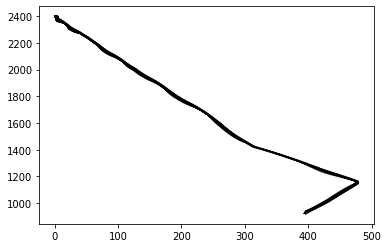

In [8]:
#plt.scatter(df["loc.x"], df["loc.y"])
#plt.axis('square')
plt.quiver(df["loc.x"], df["loc.y"], df["angle.x"], df["angle.y"])#, scale=100)
#center = (0,2500)
#radius = 10000
#plt.xlim(center[0]-radius,center[0]+radius)
#plt.ylim(center[1]-radius,center[1]+radius)

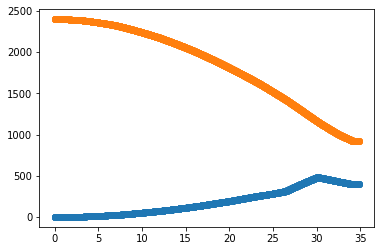

In [9]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

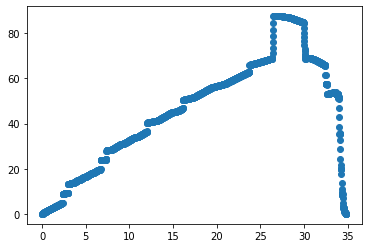

In [10]:
plt.scatter(df["ts"], df["speed"])

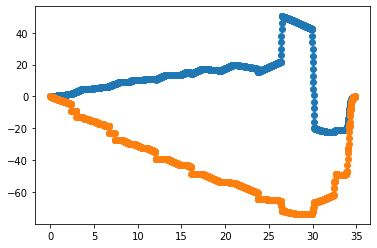

In [11]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

(0.0, 0.020000000000000993)

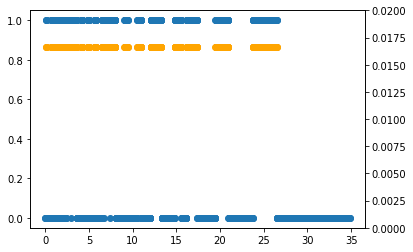

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

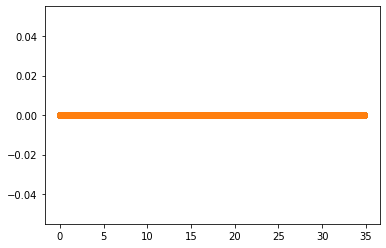

In [13]:
plt.scatter(df["ts"], df["o.cs"].fillna(0).astype(int))
plt.scatter(df["ts"], df["o.cac"].fillna(0).astype(int))

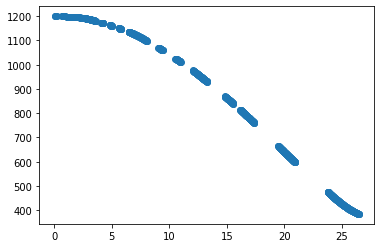

In [14]:
plt.scatter(df["ts"], df["o_ct_dist"])

In [15]:
df.groupby("o.ct")["ts"].describe()

,count,mean,std,min,25%,50%,75%,max
o.ct,,,,,,,,
771d5cf5-c555-4435-be1a-7d51917d266c,734.0,14.308401,7.945961,0.033333,7.2375,14.958333,20.645833,26.483333


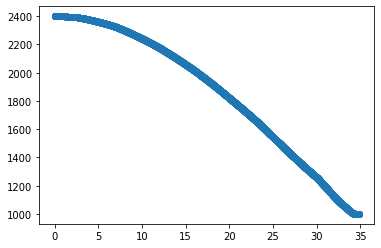

In [16]:
plt.scatter(df["ts"], df["o_t_dist"])

In [17]:
df.groupby(["o.t_loc.x", "o.t_loc.y"])["ts"].describe().sort_values(["min"])

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
0,0,2091.0,17.416667,10.062734,0.0,8.708333,17.416667,26.125,34.833333


(3000.0, 3000.0)

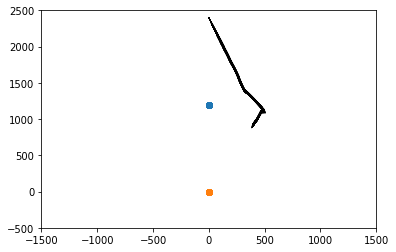

In [18]:
plt.quiver(df["loc.x"], df["loc.y"], df["v.x"], df["v.y"])
plt.scatter(df["o.ct_loc.x"], df["o.ct_loc.y"])
plt.scatter(df["o.t_loc.x"], df["o.t_loc.y"])
#plt.axis('square')
center = (0,1000)
radius = 1500
plt.xlim(center[0]-radius,center[0]+radius)
plt.ylim(center[1]-radius,center[1]+radius)
plt.gca().get_xlim()[1]-plt.gca().get_xlim()[0], plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0]